In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter


from src.detection.suspicion import SuspicionDetector
from src.detection.utils import mark_box
from real_LCMS_peak_deconvolver import LCMS_PeakDeconvolver
from src.deconvolution.visualization import plot_horizontal_gmm, plot_ridges_on_grid
from real_LCMS_localization import Localizer


from src.generation.export_utils import load_mzml
from src.generation.visualization import plot_gaussians_grid

import numpy as np
import pandas as pd

c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyopenms\__init__.py:41: UserWarning: Warning: OPENMS_DATA_PATH environment variable already exists. pyOpenMS will use it (C:\Program Files\OpenMS-3.3.0\share\OpenMS) to locate data in the OpenMS share folder (e.g., the unimod database), instead of the default (c:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyopenms\share/OpenMS).
  warnings.warn(


In [2]:
rt_points = 100
mz_points = 1000

In [3]:
def grid_to_plot_df(grid, rt_axis, mz_axis):
    df_plot = pd.DataFrame({
        "rt": rt_axis,
        "mz": [mz_axis for _ in range(len(rt_axis))],
        "intensities": [row for row in grid]
    })
    return df_plot


import numpy as np

def pad_rt_derivatives(d1, d2, target_rt_len):
    """
    Pad:
      • d1 of shape (n_mz, target_rt_len−1) → (n_mz, target_rt_len)
      • d2 of shape (n_mz, target_rt_len−2) → (n_mz, target_rt_len)

    by appending zeros on the right.
    """
    n_mz, d1_rt = d1.shape
    _, d2_rt = d2.shape
    n_rt = target_rt_len

    # Pad d1 from (n_mz, n_rt−1) → (n_mz, n_rt)
    if d1_rt == n_rt - 1:
        d1_padded = np.zeros((n_mz, n_rt), dtype=d1.dtype)
        d1_padded[:, :d1_rt] = d1
        # last column remains zero
    else:
        raise ValueError(f"d1 has unexpected shape {d1.shape}, expected ({n_mz},{n_rt-1})")

    # Pad d2 from (n_mz, n_rt−2) → (n_mz, n_rt)
    if d2_rt == n_rt - 2:
        d2_padded = np.zeros((n_mz, n_rt), dtype=d2.dtype)
        d2_padded[:, :d2_rt] = d2
        # last two columns remain zero
    else:
        raise ValueError(f"d2 has unexpected shape {d2.shape}, expected ({n_mz},{n_rt-2})")

    return d1_padded, d2_padded


In [4]:
def build_grid_from_dataframe(df, rt_bin_size=0.1, mz_bin_size=0.01):
    # Step 1: Flatten all (rt, mz, intensity) triples
    rt_all = []
    mz_all = []
    int_all = []

    for _, row in df.iterrows():
        rt = row["RT"]
        mzs = row["mzarray"]
        ints = row["intarray"]

        rt_all.extend([rt] * len(mzs))
        mz_all.extend(mzs)
        int_all.extend(ints)

    rt_all = np.array(rt_all)
    mz_all = np.array(mz_all)
    int_all = np.array(int_all)

    # Step 2: Create axis bins
    rt_min, rt_max = rt_all.min(), rt_all.max()
    mz_min, mz_max = mz_all.min(), mz_all.max()

    rt_axis = np.arange(rt_min, rt_max + rt_bin_size, rt_bin_size)
    mz_axis = np.arange(mz_min, mz_max + mz_bin_size, mz_bin_size)

    # Step 3: Create empty grid
    grid = np.zeros((len(rt_axis), len(mz_axis)), dtype=np.float32)

    # Step 4: Populate grid
    rt_indices = np.searchsorted(rt_axis, rt_all, side='right') - 1
    mz_indices = np.searchsorted(mz_axis, mz_all, side='right') - 1

    valid = (rt_indices >= 0) & (rt_indices < len(rt_axis)) & \
            (mz_indices >= 0) & (mz_indices < len(mz_axis))

    for r_idx, m_idx, intensity in zip(rt_indices[valid], mz_indices[valid], int_all[valid]):
        grid[r_idx, m_idx] += intensity

    return grid, rt_axis, mz_axis


In [5]:
# 1. Load real LC-MS data
data_loaded = load_mzml(r"C:\Users\\victo\VSCode Folder\UMCG Mass Spec\\3_2_extract_overlap_1.mzML")
if "ms_level" in data_loaded.columns:
    data_loaded = data_loaded.drop("ms_level", axis=1)
        
print(data_loaded.head())

grid, rt_axis, mz_axis = build_grid_from_dataframe(data_loaded)

           RT                                            mzarray  \
0  2982.78870  [548.6595438612912, 548.6625912113475, 548.665...   
1  2983.20168  [548.6137949054772, 548.61684187451, 548.61988...   
2  2984.01666  [548.6138211331556, 548.6168681023341, 548.619...   
3  2985.14556  [548.6138475127875, 548.6168944821125, 548.619...   
4  2987.20332  [548.6107912053993, 548.6138381492885, 548.616...   

                                            intarray  
0  [48871.57, 93090.67, 119617.8, 105596.12, 5844...  
1  [59790.492, 110884.73, 140389.9, 125135.02, 77...  
2  [46852.145, 96281.12, 124956.57, 108827.82, 62...  
3  [54953.508, 96425.24, 116641.32, 97879.38, 541...  
4  [60526.164, 89810.484, 101158.25, 86533.97, 50...  


In [6]:
print(data_loaded["RT"].describe())

# 1) "Explode" the mzarray column so that each m/z in the lists becomes its own row:
df_exploded = data_loaded.explode("mzarray")

# 2) Convert the exploded values to float (they may already be float, but just to be sure):
df_exploded["mzarray"] = df_exploded["mzarray"].astype(float)

# 3) Now find min and max in the exploded column:
mz_min = df_exploded["mzarray"].min()
mz_max = df_exploded["mzarray"].max()

print(f"Global m/z min = {mz_min:.6f}")
print(f"Global m/z max = {mz_max:.6f}")

count     161.000000
mean     3046.764740
std        37.489931
min      2982.788700
25%      3014.804700
50%      3042.811020
75%      3079.571760
max      3112.435440
Name: RT, dtype: float64
Global m/z min = 548.461440
Global m/z max = 548.683906


In [7]:
rt_points = 100 
mz_points = 200
rt_min = 2982
rt_max = 3112
mz_min = 548.461440
mz_max = 548.683906

In [8]:
rt_axis = np.linspace(rt_min, rt_max, rt_points)    # shape = (100,)
mz_axis = np.linspace(mz_min, mz_max, mz_points)    # shape = (1000,)

In [9]:
# Check the bin widths:
ΔRT = rt_axis[1] - rt_axis[0]    # about (3112.4354 – 2982.7887)/(100 – 1) ≃ 1.299
Δmz = mz_axis[1] - mz_axis[0]    # about (mz_max – mz_min)/(1000 – 1)
print(f"ΔRT = {ΔRT:.6f}, Δmz = {Δmz:.8f}")

ΔRT = 1.313131, Δmz = 0.00111792


In [10]:
rt_edges = np.concatenate([
    [rt_axis[0] - ΔRT/2],
    (rt_axis[:-1] + rt_axis[1:]) / 2,
    [rt_axis[-1] + ΔRT/2]
])  # shape = (101,)

mz_edges = np.concatenate([
    [mz_axis[0] - Δmz/2],
    (mz_axis[:-1] + mz_axis[1:]) / 2,
    [mz_axis[-1] + Δmz/2]
])  # shape = (1001,)

# Quick sanity-check on edges:
assert len(rt_edges) == rt_points + 1
assert len(mz_edges) == mz_points + 1

In [11]:
mask_in_box = (
    (data_loaded["RT"] >= rt_min) & (data_loaded["RT"] <= rt_max)
)

In [12]:
filtered = data_loaded.loc[mask_in_box].reset_index(drop=True)
long_df = filtered.explode(["mzarray", "intarray"]).copy()
long_df[["mzarray", "intarray"]] = long_df[["mzarray", "intarray"]].astype(float)
mask_mz = (long_df["mzarray"] >= mz_min) & (long_df["mzarray"] <= mz_max)
long_df = long_df.loc[mask_mz].reset_index(drop=True)

In [13]:
long_df["rt_bin"]   = np.digitize(long_df["RT"].values, rt_edges)     # returns 1..100 for bins
long_df["rt_index"] = long_df["rt_bin"] - 1    
long_df["mz_bin"]   = np.digitize(long_df["mzarray"].values, mz_edges) # returns 1..1000 for bins
long_df["mz_index"] = long_df["mz_bin"] - 1      
                      # now 0..999
mask_rt_valid = (long_df["rt_index"] >= 0) & (long_df["rt_index"] < rt_points)
mask_mz_valid = (long_df["mz_index"] >= 0) & (long_df["mz_index"] < mz_points)
long_df = long_df.loc[mask_rt_valid & mask_mz_valid].reset_index(drop=True)

In [14]:
intensity_grid = np.zeros((mz_points, rt_points), dtype=float)
for _, row in long_df.iterrows():
    r_idx = int(row["rt_index"])   # between 0 and 99
    m_idx = int(row["mz_index"])   # between 0 and 999
    I    = float(row["intarray"])
    intensity_grid[m_idx, r_idx] += I

smoothed_grid = gaussian_filter(intensity_grid, sigma=(2, 2))
intensity_grid = smoothed_grid

In [15]:
rows = []
for j in range(rt_points):
    # Find all (m_idx,r_idx) that contributed to RT‐bin = j.  We can just filter `long_df`.
    sub = long_df[long_df["rt_index"] == j]
    if sub.shape[0] == 0:
        # If no points fell in this RT‐bin, we still create an “empty” row:
        rows.append({
            "rt"         : float(rt_axis[j]),
            "mz"         : np.array([], dtype=float),
            "intensities": np.array([], dtype=float)
        })
    else:
        # “sub” is a slice of all points at RT‐ bin j; each has its own m/z and intensity:
        rows.append({
            "rt"         : float(rt_axis[j]),
            "mz"         : sub["mzarray"].values.astype(float),
            "intensities": sub["intarray"].values.astype(float)
        })

gaussians_df_real = pd.DataFrame(rows)

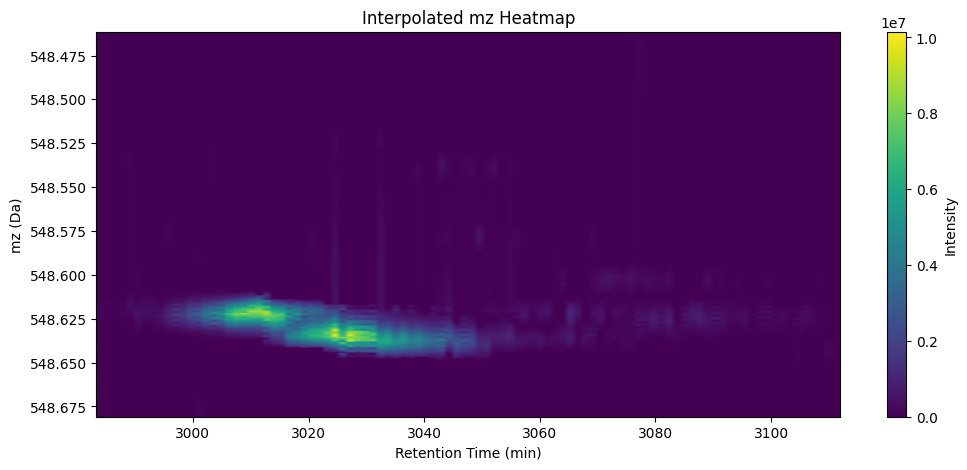

In [16]:
mask_nonzero = gaussians_df_real["mz"].apply(len) > 0
gaussians_df_nonempty = gaussians_df_real.loc[mask_nonzero].reset_index(drop=True)

# Now this new DataFrame has no “empty” rows, so plot_gaussians_grid won’t crash:
from src.generation.visualization import plot_gaussians_grid
plot_gaussians_grid(gaussians_df_nonempty)

In [17]:
region_rows = []
runtime_stats = { "GMM": 0.0, "RidgeWalker": 0.0, "Wavelet": 0.0 }

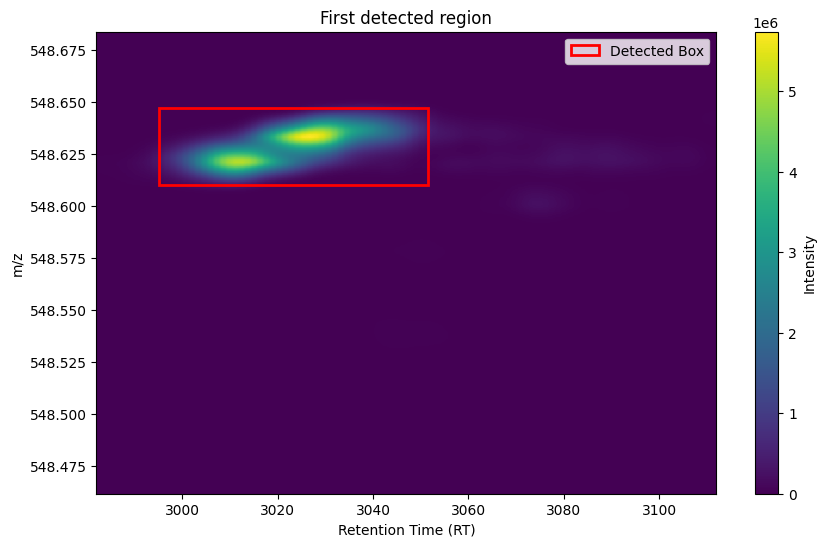

In [18]:
# 3. Region detection
processed = np.full(intensity_grid.shape, 'unprocessed', object)
lzr = Localizer(intensity_grid, mz_axis, rt_axis, processed)
cropped = []

while 'unprocessed' in processed:
    box = lzr.find_next_active_box(global_intensity_thresh=0.15, local_margin=2)
    if not box:
        break
    sub, mzi, rti = lzr.crop_box(box)
    sd = SuspicionDetector(sub, mzi, rti)
    is_susp, _ = sd.detect_suspicious(plot=False)
    mark_box(processed, box, 'processed')
    lzr.plot_box_on_grid(box, title="First detected region")
    if is_susp:
        cropped.append((sub, mzi, rti, sd.d_grid_rt, sd.dd_grid_rt))

[GMM] Accepted best_k=2 (ΔBIC=117.55, support=very strong, sep=0.93)


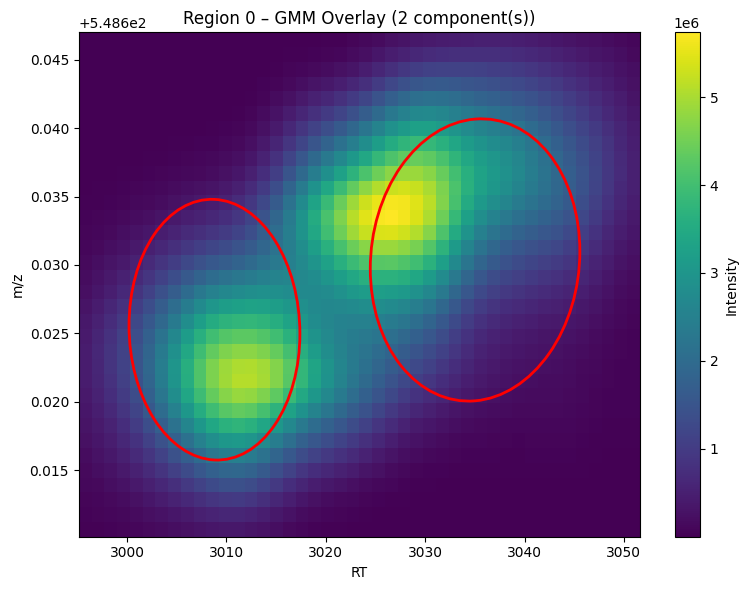

sub.shape   =  (34, 44)
d1.shape    =  (34, 43)
d2.shape    =  (34, 42)
len(mzi)    =  34
len(rti)    =  44


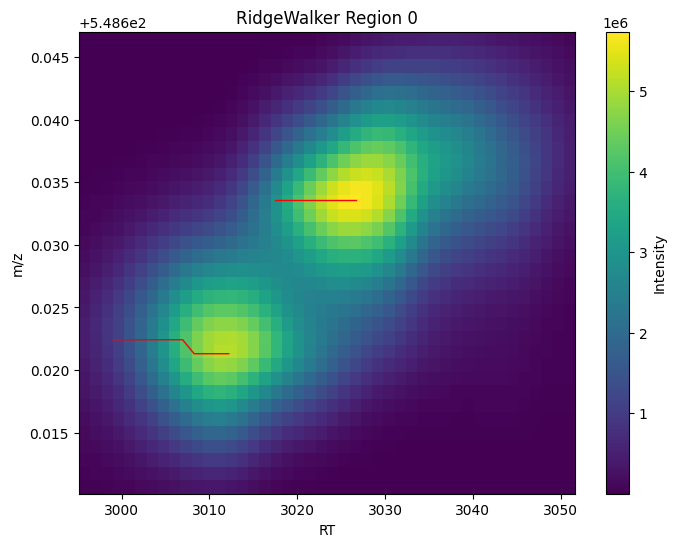

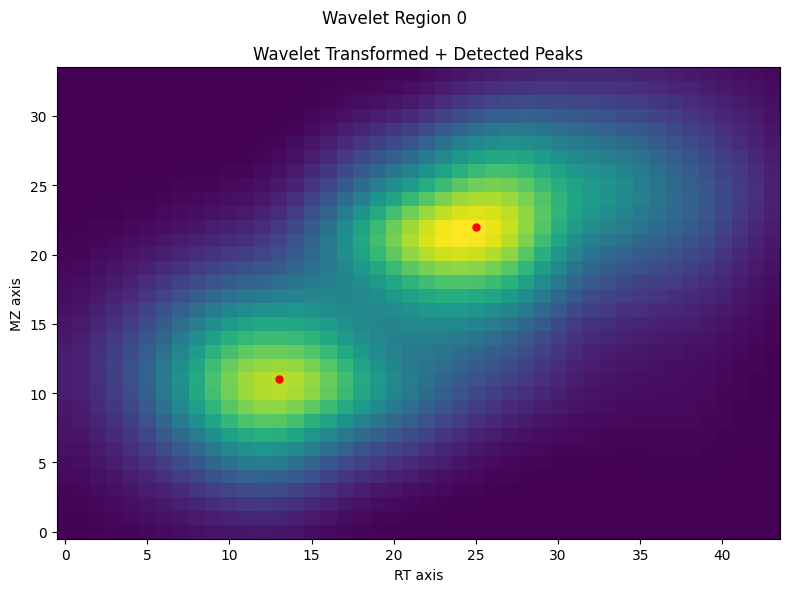

In [19]:
import time

models = {
        "GMM":         LCMS_PeakDeconvolver(method="gmm").model,
        "RidgeWalker": LCMS_PeakDeconvolver(method="ridge_walk").model,
        "Wavelet":     LCMS_PeakDeconvolver(method="wavelet", pad_grid=True).model
    }

for region_idx, (sub, mzi, rti, d1, d2) in enumerate(cropped):
    for model_name, model in models.items():
        start = time.time()
            
        if model_name == "GMM":
            res = model.fit(sub, mzi, rti, plot_func=plot_horizontal_gmm)
        elif model_name == "RidgeWalker":
            # d1 = sd.d_grid_rt, d2 = sd.dd_grid_rt; sub.shape = (n_mz_sub, n_rt_sub)
            print("sub.shape   = ", sub.shape)
            print("d1.shape    = ", d1.shape)
            print("d2.shape    = ", d2.shape)
            print("len(mzi)    = ", len(mzi))
            print("len(rti)    = ", len(rti))

            n_mz_sub, n_rt_sub = sub.shape
            d1a, d2a = pad_rt_derivatives(d1, d2, target_rt_len=n_rt_sub)

            # Now call fit with the corrected derivatives
            res = model.fit(sub, d1a, d2a, mzi, rti)
            plot_ridges_on_grid(sub, mzi, rti, model.ridges,
                                title=f"{model_name} Region {region_idx}")
        elif model_name == "Wavelet":
            res = model.fit(sub, mzi, rti)
            model.plot_wavelet_result(
                    res["transformed_grid"],
                    res["peaks"],
                    res["clusters"],
                    title=f"{model_name} Region {region_idx}")
        else:
            res = model.fit(sub, mzi, rti)
            
        runtime_stats[model_name] += time.time() - start

        # === Log outputs as before ===
        row = {
            "region_idx": region_idx,
            "model": model_name,
            "num_peaks": len(res.get("peak_locations", [])),
            "confidence": res.get("confidence", None),
            "fusion_score": res.get("fusion_score", None),
            "runtime": runtime_stats[model_name],}
        region_rows.append(row)

In [20]:
import csv
# 6. Save result table
with open("real_LCMS_TEST.csv", "w", newline="") as fout:
    writer = csv.DictWriter(fout, fieldnames=region_rows[0].keys())
    writer.writeheader()
    for r in region_rows:
        writer.writerow(r)
# 7. Print summary
total_runtime = sum(runtime_stats.values())
print("\n=== REAL DATA RUNTIME SUMMARY ===")
for model, t in runtime_stats.items():
    pct = (t / total_runtime) * 100 if total_runtime else 0
    print(f"{model}: {t:.2f}s ({pct:.1f}%)")


=== REAL DATA RUNTIME SUMMARY ===
GMM: 0.49s (53.9%)
RidgeWalker: 0.16s (17.0%)
Wavelet: 0.27s (29.1%)
